In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'SZU.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date,Unnamed: 22,Unnamed: 23
0,2014-05-31,1773,0,1773,77,0,987,1897,3855,0,...,725,1920,674,3600,152,-66,204.20,2014-07-10,NaN,NaN
1,2014-08-31,1709,0,1709,42,0,960,1437,3396,0,...,538,1635,671,3412,94,-102,204.20,2014-10-09,NaN,NaN
2,2014-11-30,1752,0,1752,9,0,955,2105,4091,0,...,391,2301,679,4092,138,-99,204.20,2015-01-13,NaN,NaN
3,2015-02-28,1544,0,1544,-54,0,870,2128,3964,0,...,500,2128,774,4013,5,-120,204.18,2015-04-24,NaN,NaN
4,2015-05-31,1629,0,1629,41,0,998,1777,3679,0,...,681,1795,771,3682,102,-73,204.20,2015-07-09,NaN,NaN


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-05-31,2023-07-12,204.1,2518,0,2518,198,0,1458,2925,...,934,9561,1081,0,742,2467,1668,5308,-3,-79
37,2023-08-31,2023-10-12,204.1,2560,0,2560,211,0,1480,2479,...,922,9184,652,0,910,2167,1571,4820,371,-120
38,2023-11-30,2024-01-11,204.1,2701,0,2701,187,0,1546,3315,...,917,9984,1664,0,496,2783,1564,5442,416,-129
39,2024-02-29,2024-04-26,204.1,2510,0,2510,52,0,1456,3511,...,917,10278,1970,0,513,3152,1707,6005,289,-218
40,2024-05-31,2024-07-12,204.1,2551,0,2551,94,0,1480,2912,...,913,9656,1361,0,350,2387,1701,5228,289,-113


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-05-31,2023-07-12,204.1,2518,0,2518,198,0,1458,2925,...,9561,1081,0,742,2467,1668,5308,-3,-79,0.921941
37,2023-08-31,2023-10-12,204.1,2560,0,2560,211,0,1480,2479,...,9184,652,0,910,2167,1571,4820,371,-120,0.914382
38,2023-11-30,2024-01-11,204.1,2701,0,2701,187,0,1546,3315,...,9984,1664,0,496,2783,1564,5442,416,-129,0.936394
39,2024-02-29,2024-04-26,204.1,2510,0,2510,52,0,1456,3511,...,10278,1970,0,513,3152,1707,6005,289,-218,0.919421
40,2024-05-31,2024-07-12,204.1,2551,0,2551,94,0,1480,2912,...,9656,1361,0,350,2387,1701,5228,289,-113,0.925874


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-05-31,2023-07-12,204.1,2518,0,2518,198,0,1458,2925,...,9561,1081,0,742,2467,1668,5308,-3,-79,0.921941
37,2023-08-31,2023-10-12,204.1,2560,0,2560,211,0,1480,2479,...,9184,652,0,910,2167,1571,4820,371,-120,0.914382
38,2023-11-30,2024-01-11,204.1,2701,0,2701,187,0,1546,3315,...,9984,1664,0,496,2783,1564,5442,416,-129,0.936394
39,2024-02-29,2024-04-26,204.1,2510,0,2510,52,0,1456,3511,...,10278,1970,0,513,3152,1707,6005,289,-218,0.919421
40,2024-05-31,2024-07-12,204.1,2551,0,2551,94,0,1480,2912,...,9656,1361,0,350,2387,1701,5228,289,-113,0.925874


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-14,10.298119,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.566422,0.433578,0.0,0.0,0.0,0.0,1.0,0.043429,0.0,0.0
1,2014-07-21,10.468884,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.566422,0.433578,0.0,0.0,0.0,0.0,1.0,0.043429,0.0,0.0
2,2014-07-28,9.904327,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.566422,0.433578,0.0,0.0,0.0,0.0,1.0,0.043429,0.0,0.0
3,2014-08-04,9.555744,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.566422,0.433578,0.0,0.0,0.0,0.0,1.0,0.043429,0.0,0.0
4,2014-08-11,9.919484,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.566422,0.433578,0.0,0.0,0.0,0.0,1.0,0.043429,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-14,10.298119,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.0,1.0,0.043429,0.0,0.0,inf,0.447135,inf,inf,inf
1,2014-07-21,10.468884,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.0,1.0,0.043429,0.0,0.0,inf,0.454549,inf,inf,inf
2,2014-07-28,9.904327,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.0,1.0,0.043429,0.0,0.0,inf,0.430037,inf,inf,inf
3,2014-08-04,9.555744,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.0,1.0,0.043429,0.0,0.0,inf,0.414902,inf,inf,inf
4,2014-08-11,9.919484,2014-05-31,1773.0,0.0,23.031342,204.2,0.0,0.0,0.0,...,0.0,1.0,0.043429,0.0,0.0,inf,0.430695,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

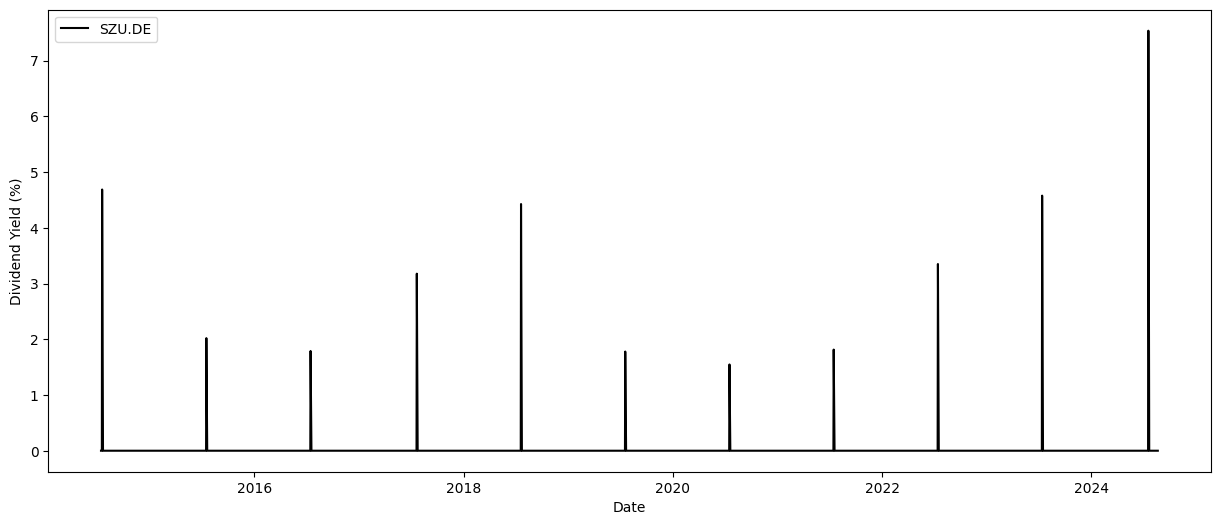

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.324164
share_price      1.000000
Name: share_price, dtype: float64


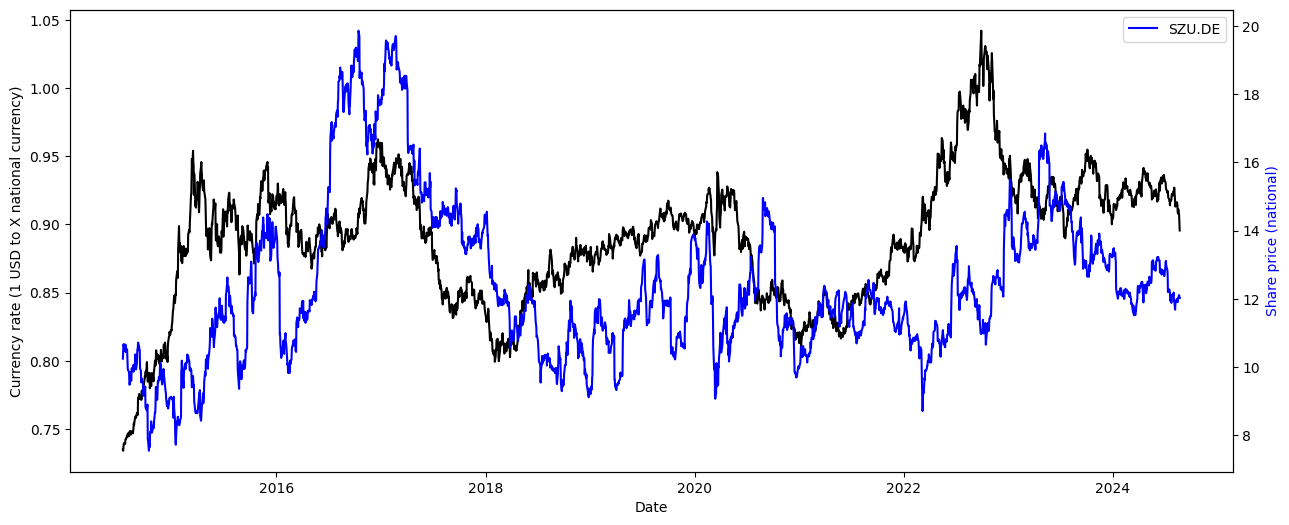

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

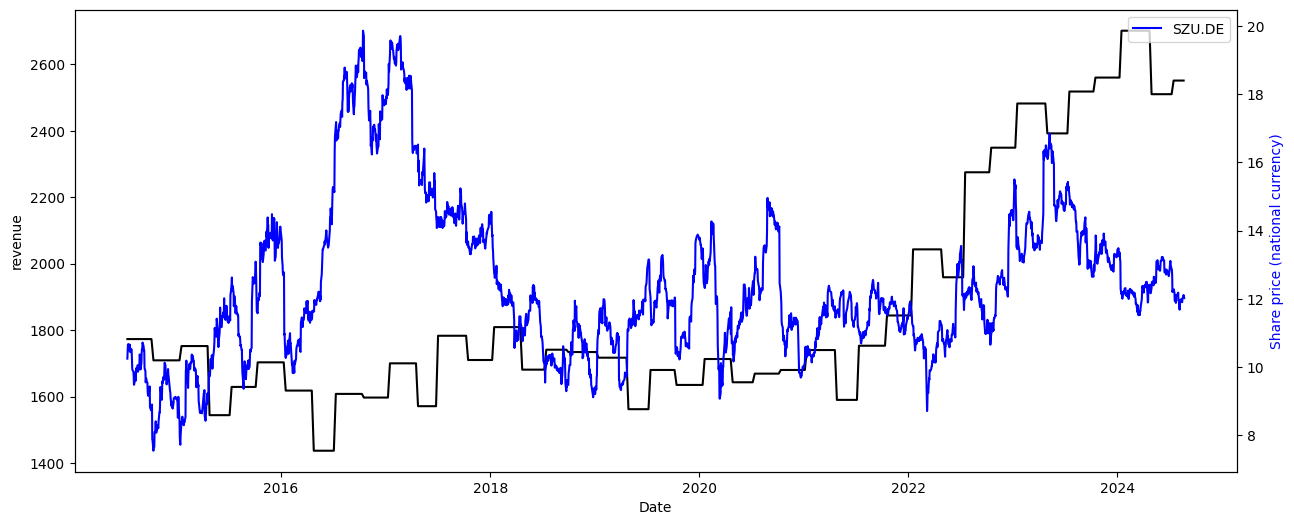

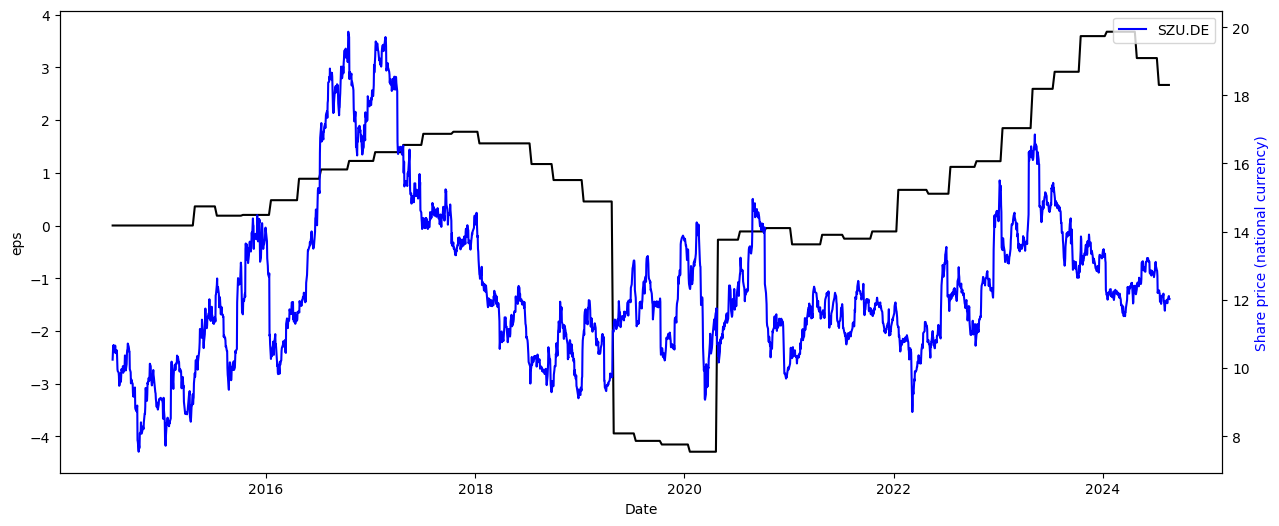

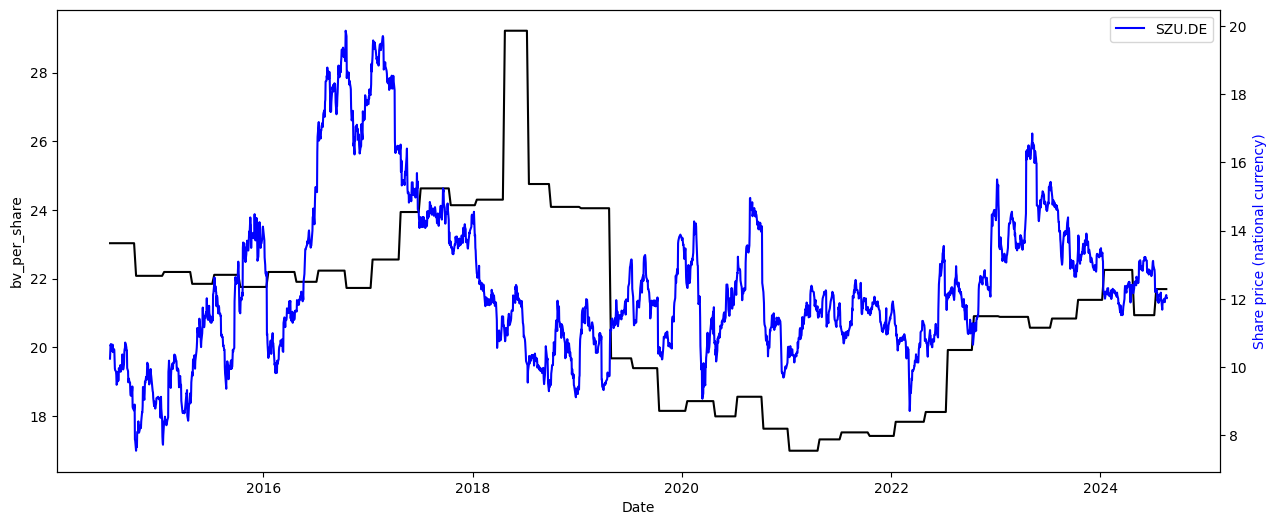

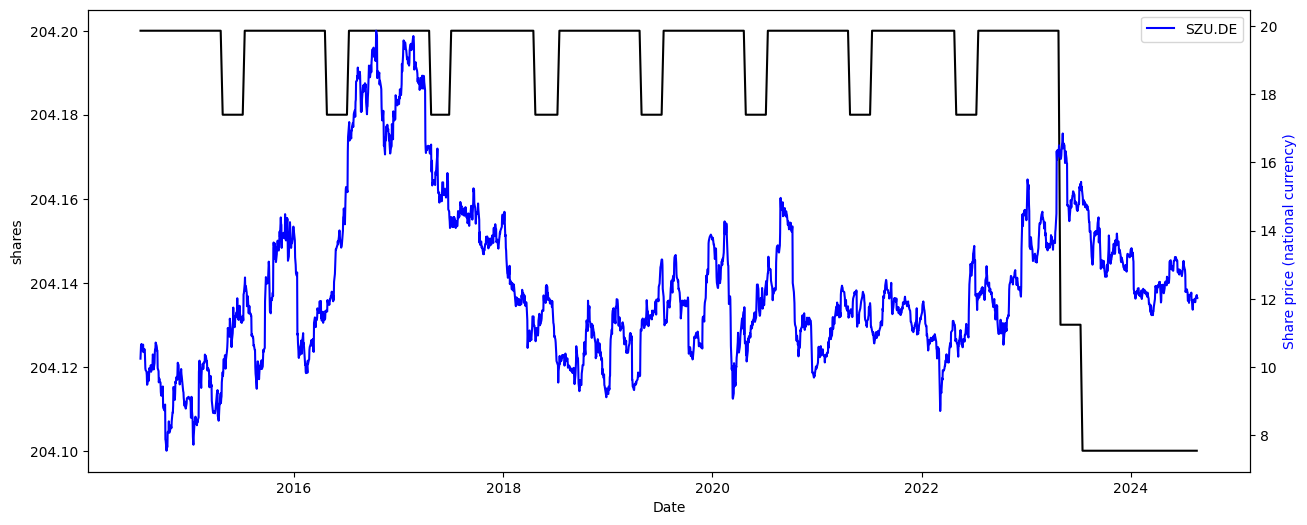

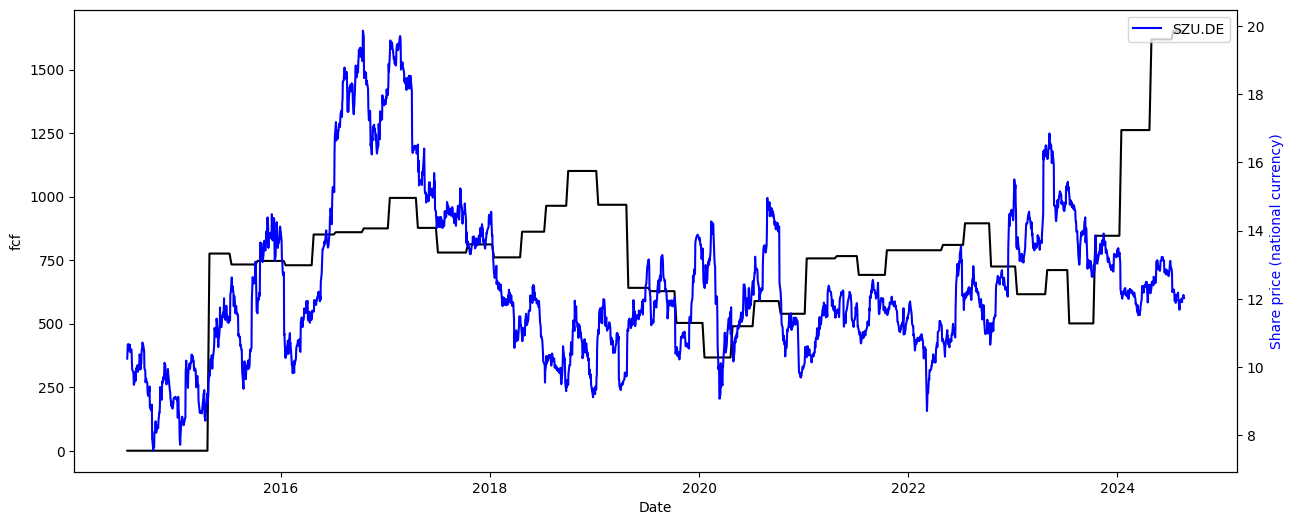

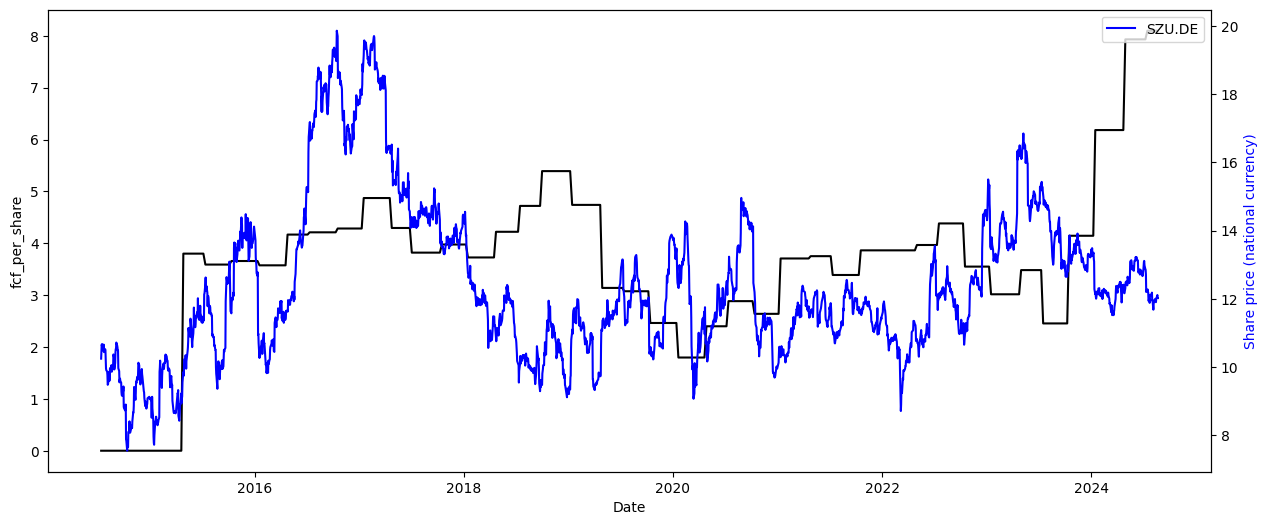

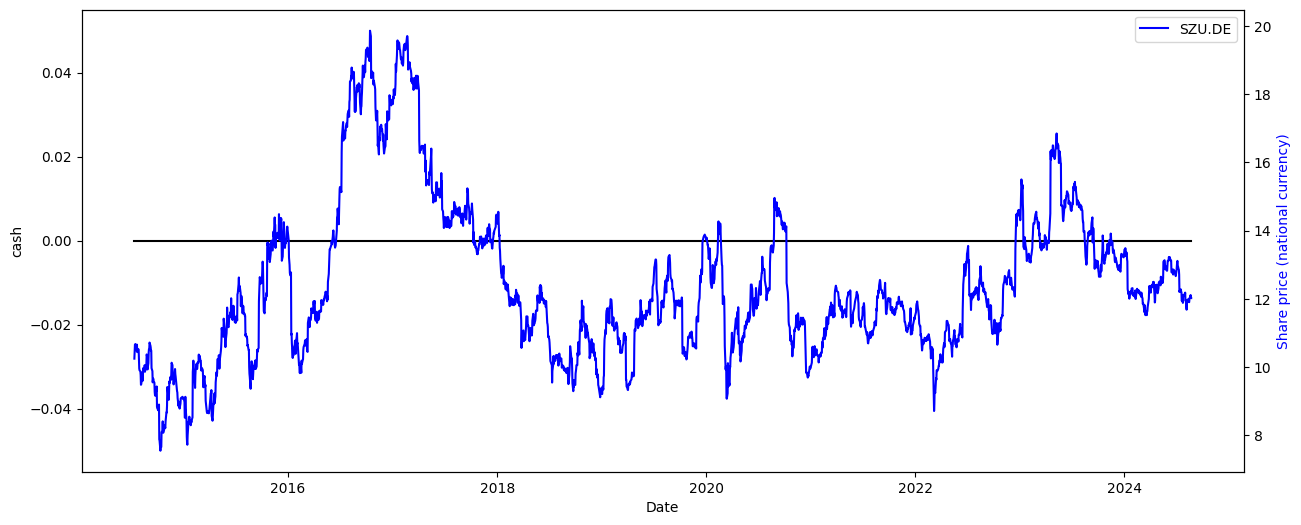

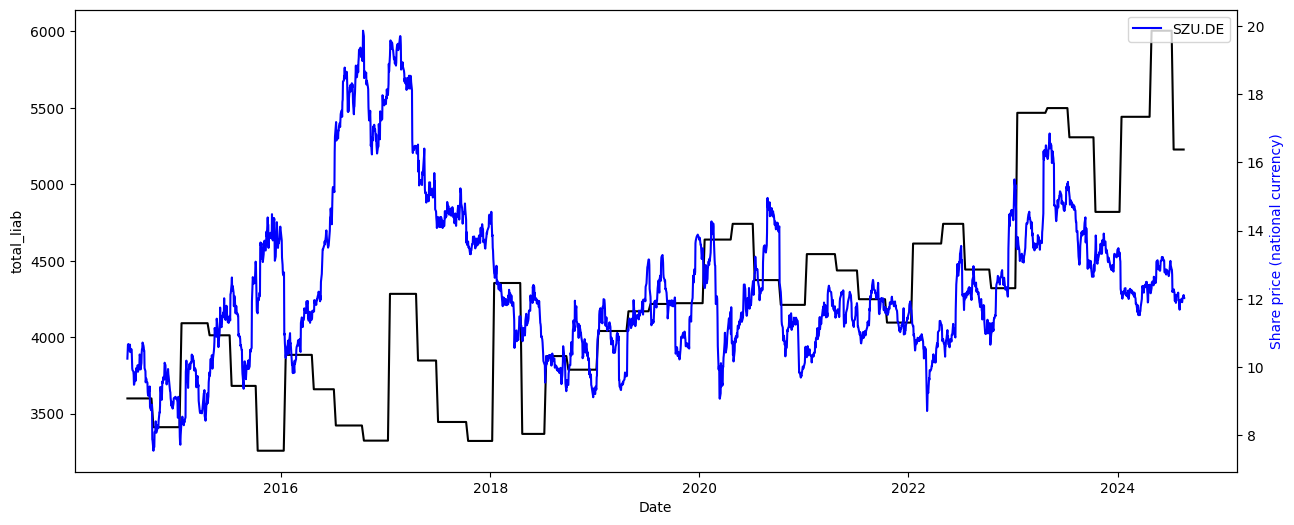

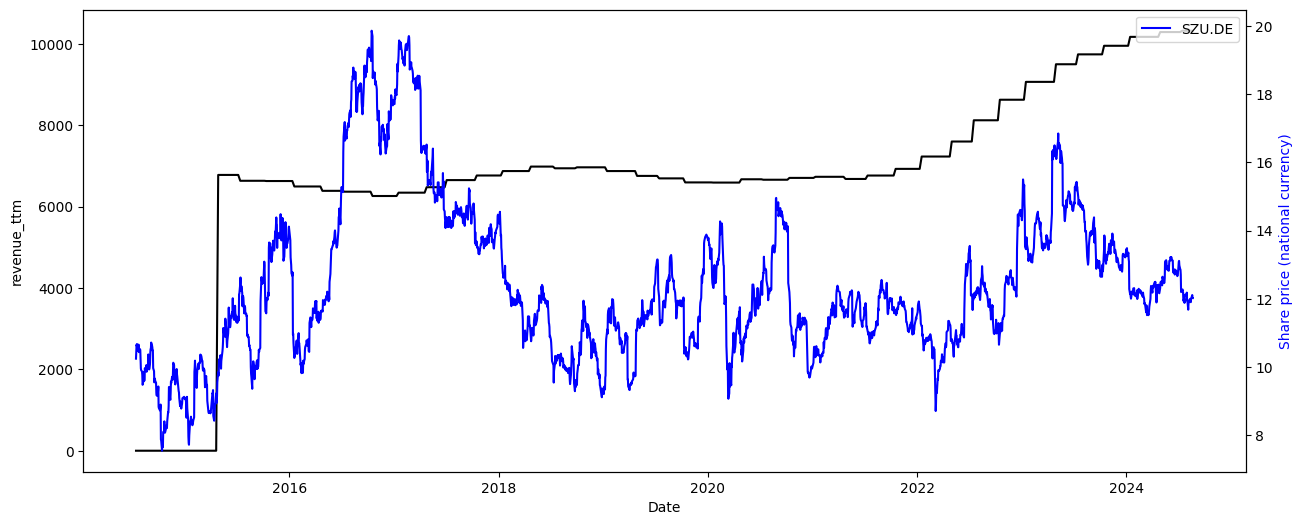

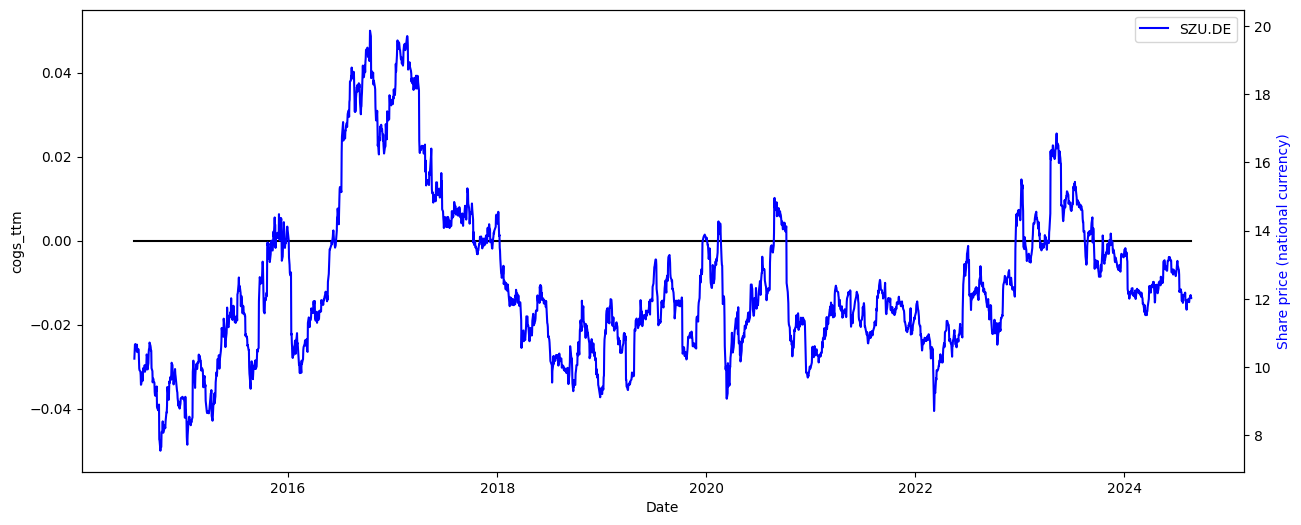

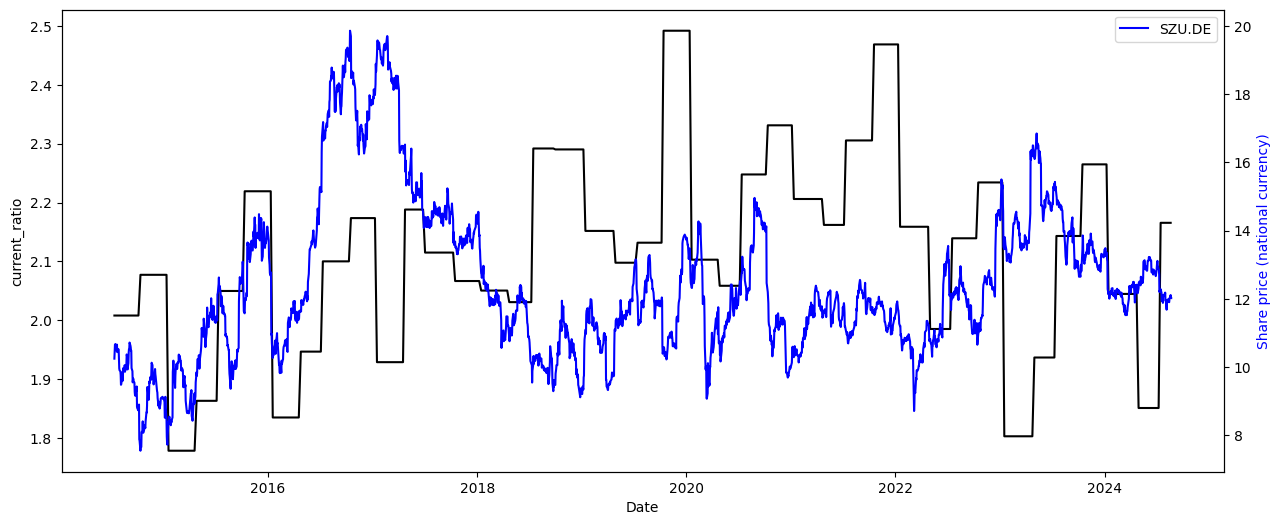

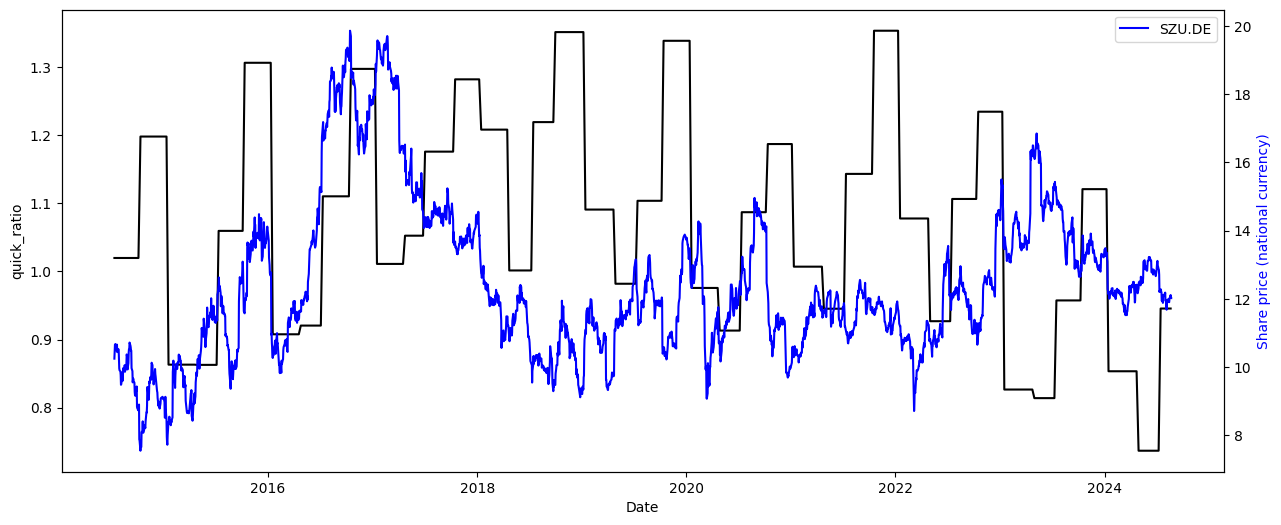

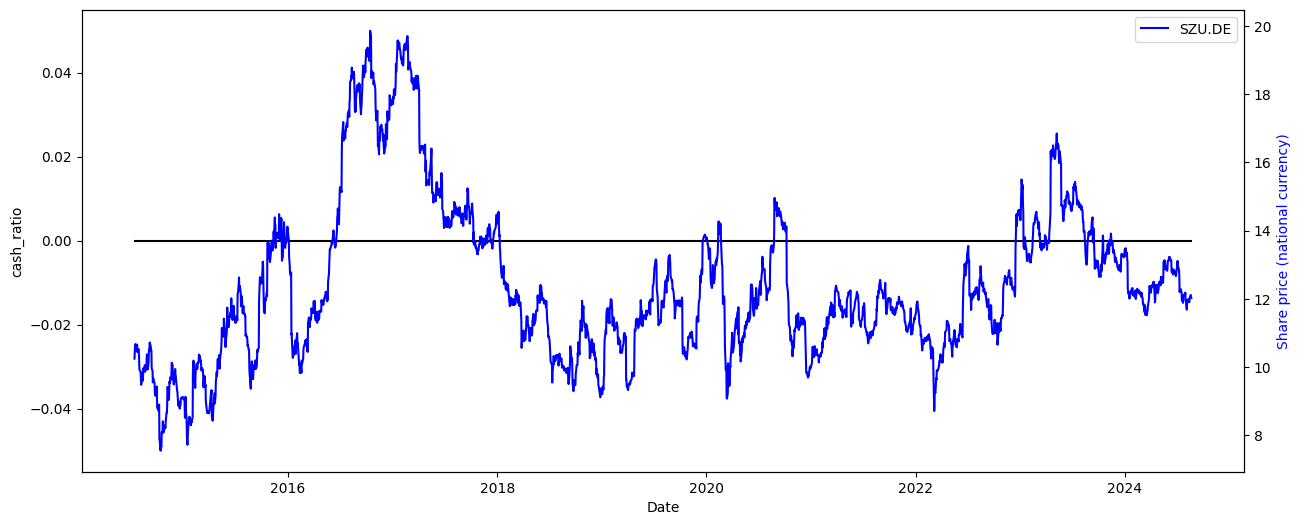

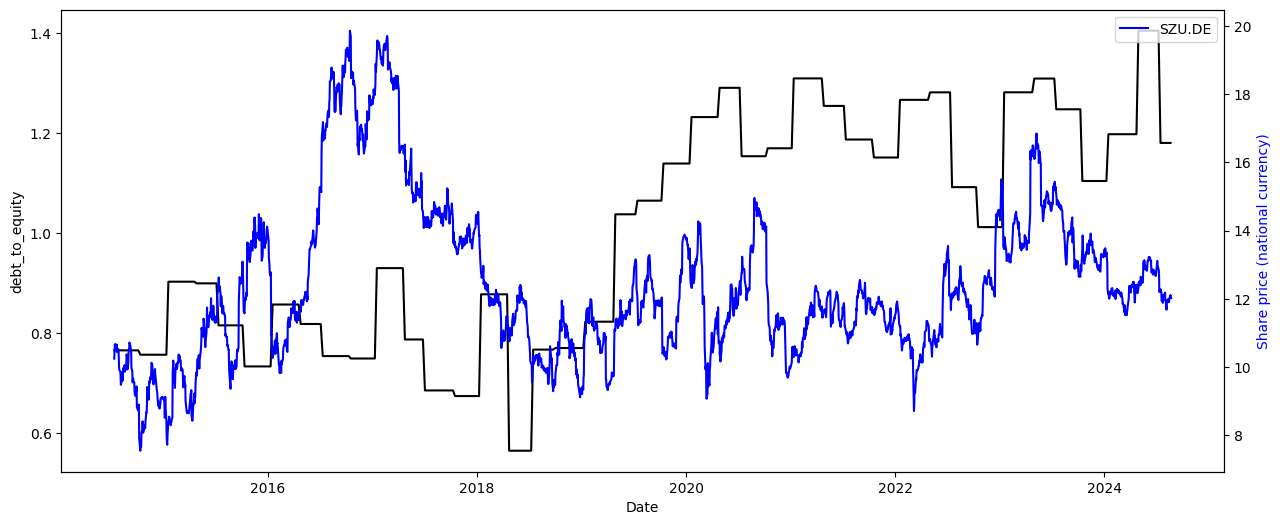

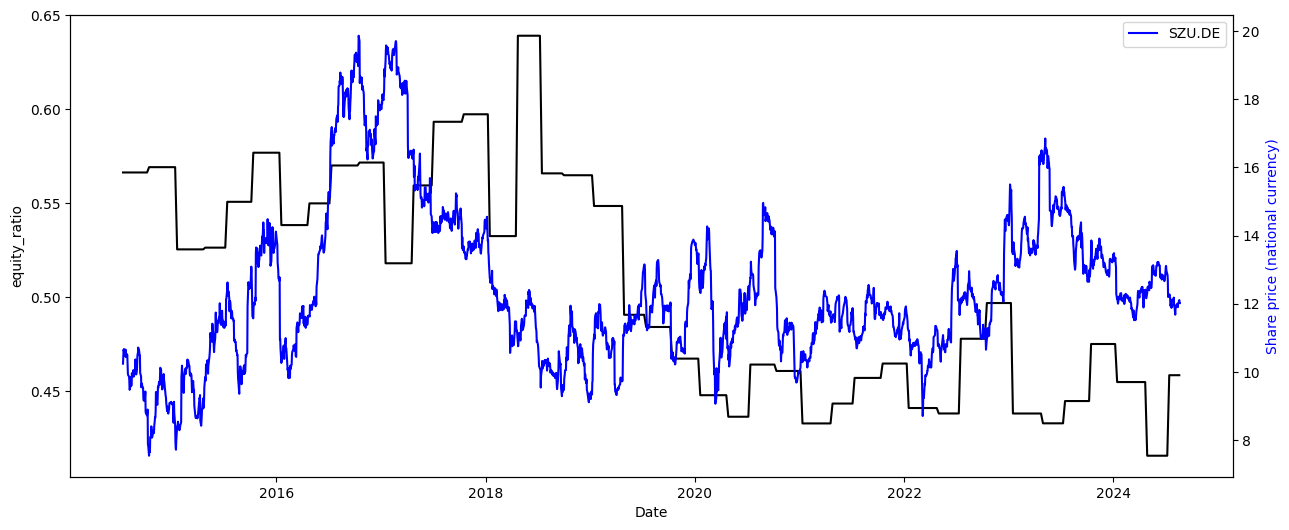

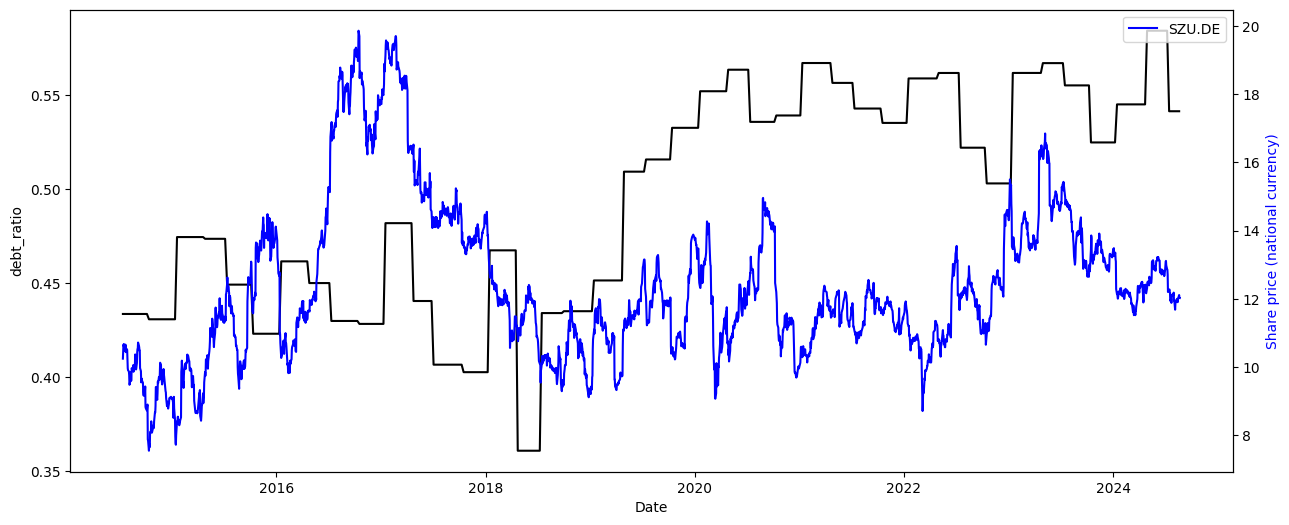

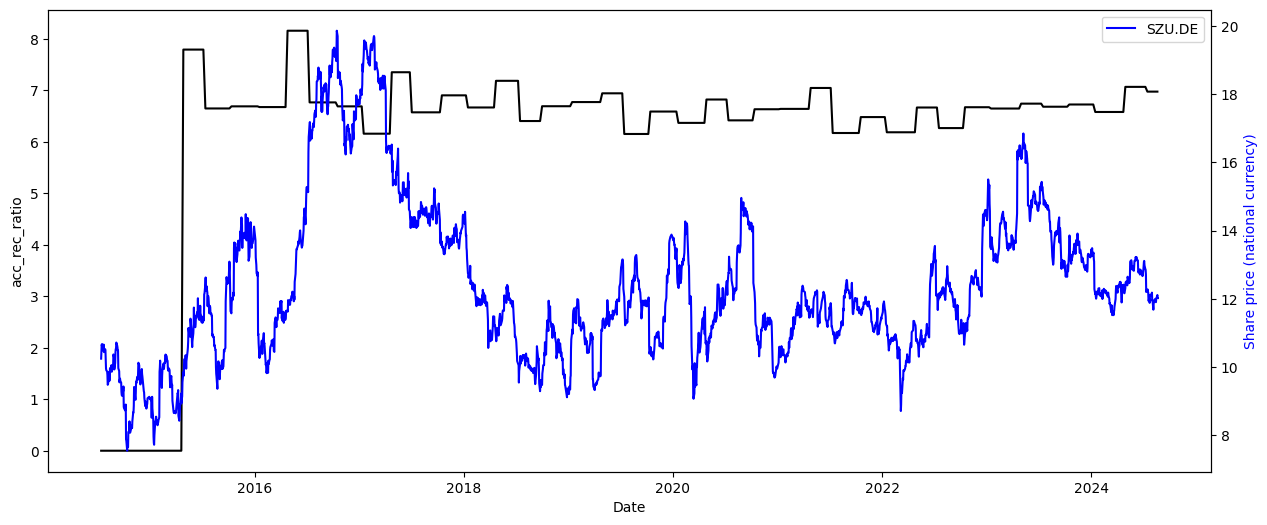

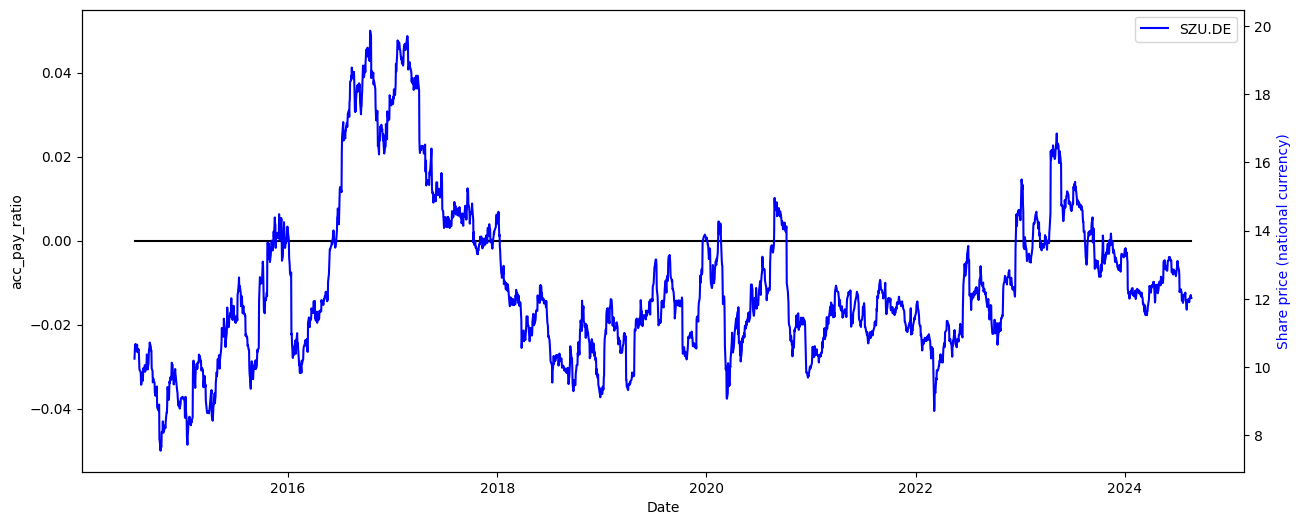

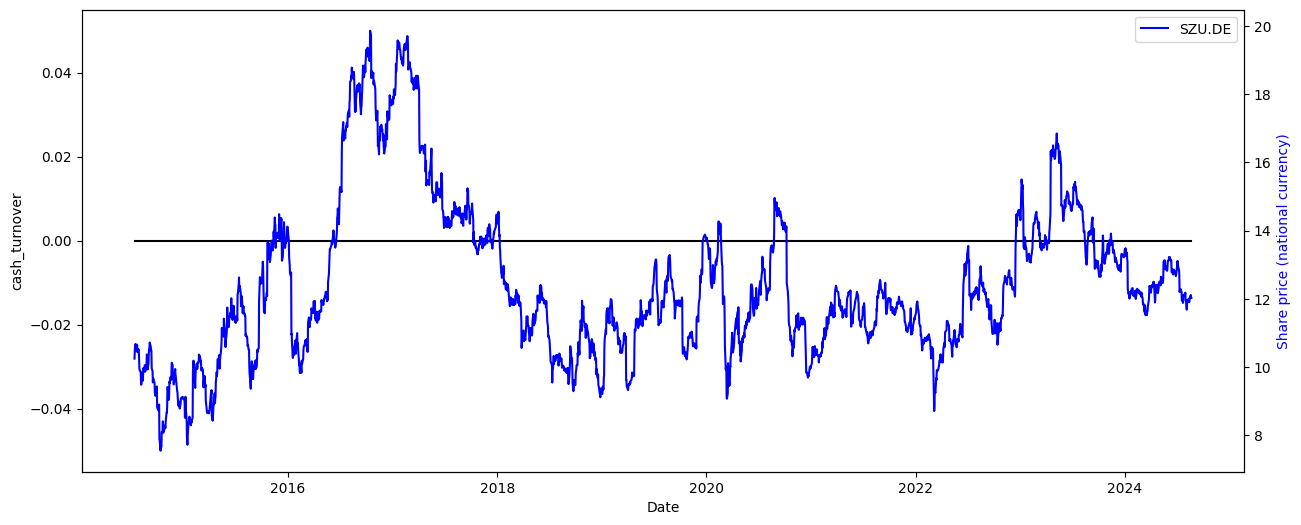

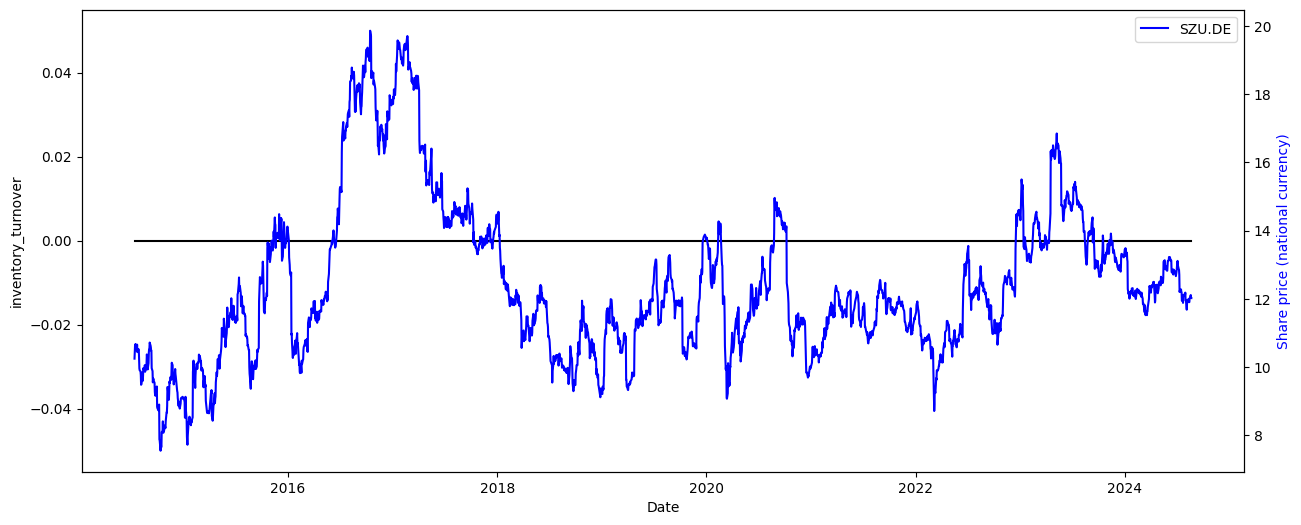

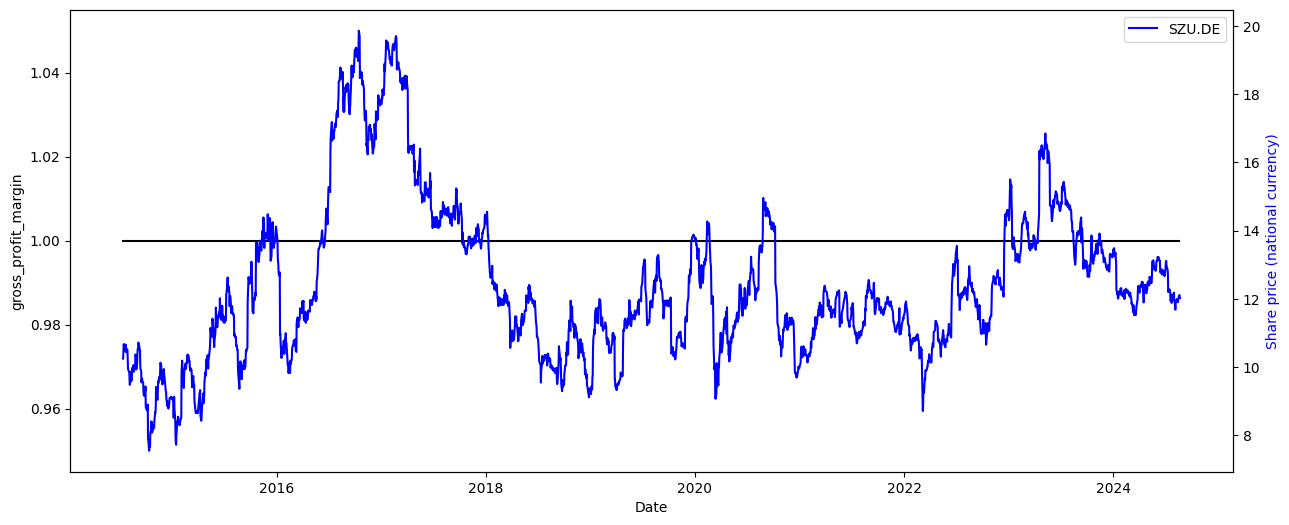

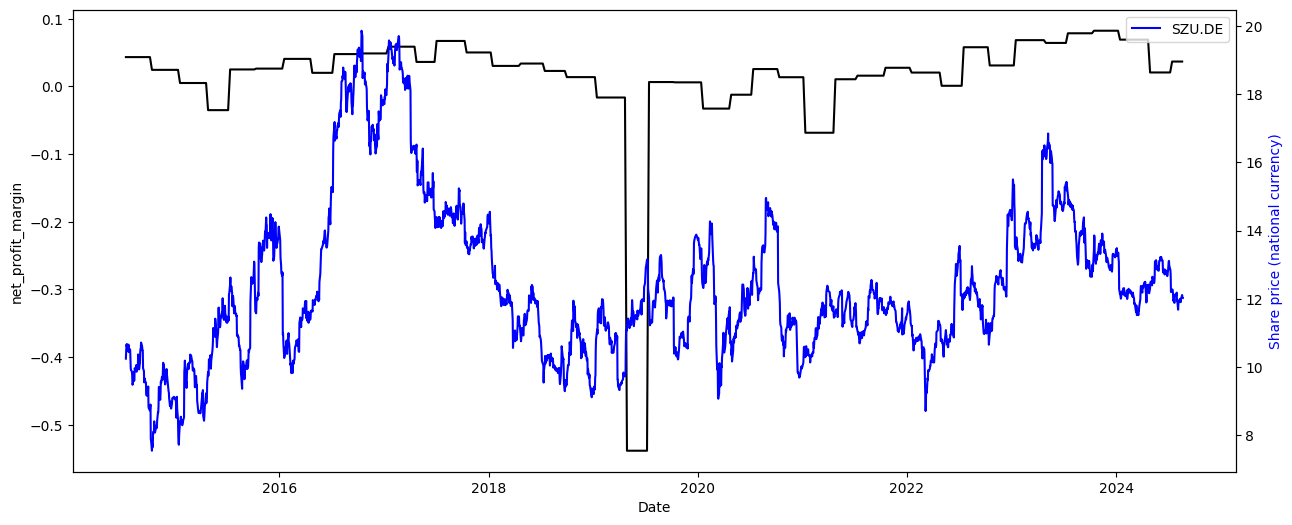

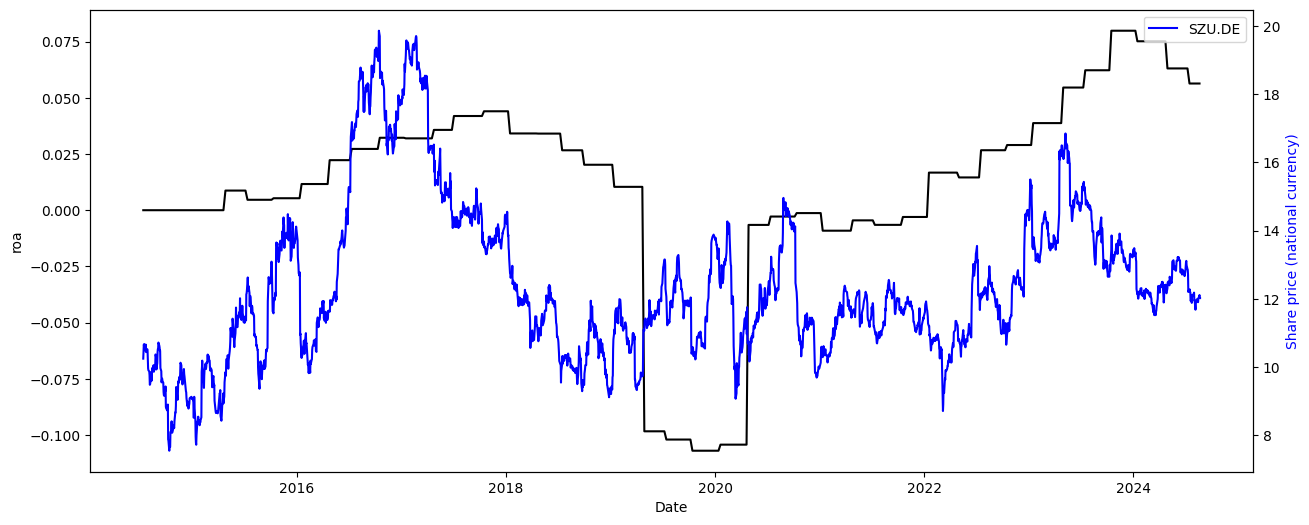

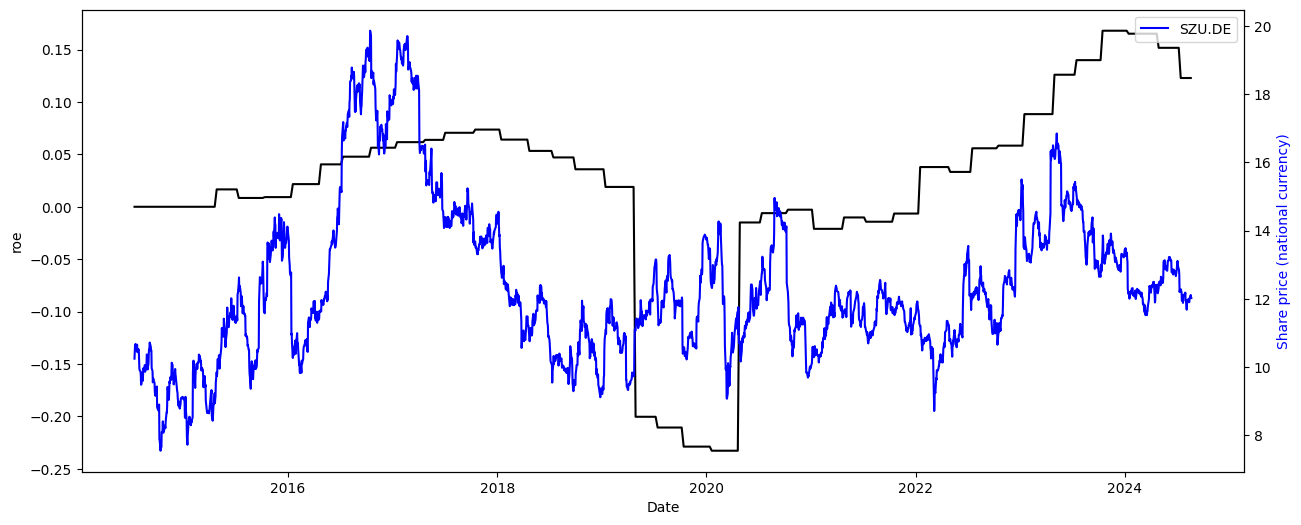

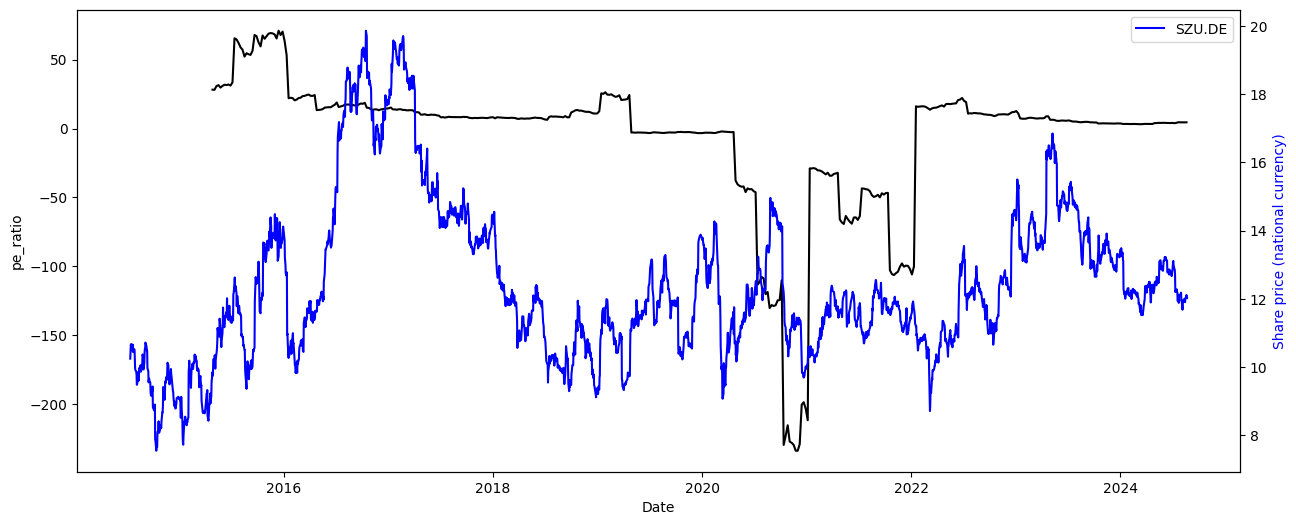

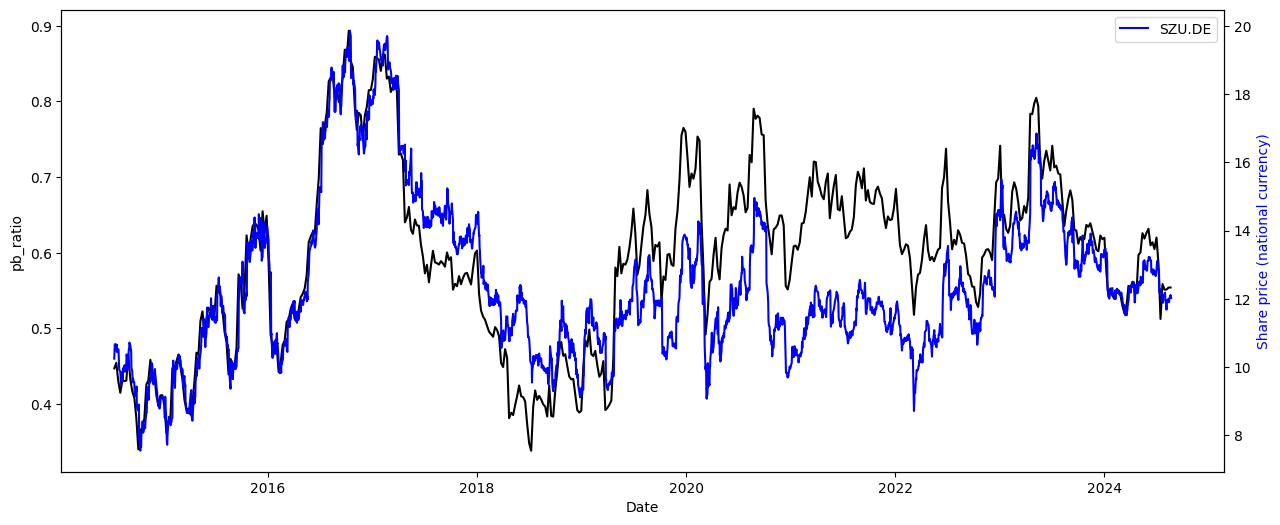

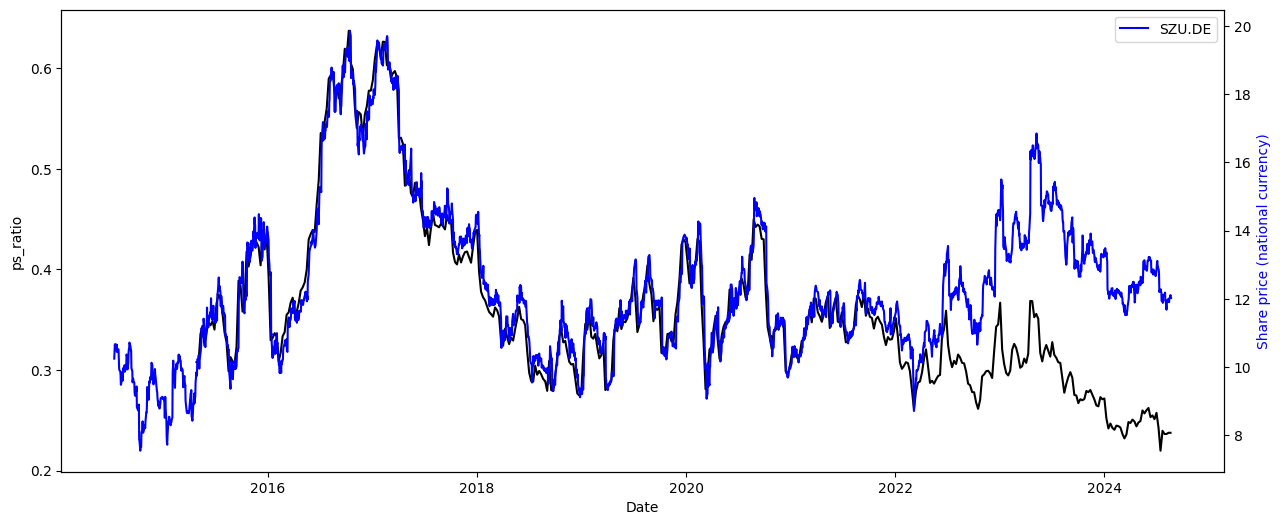

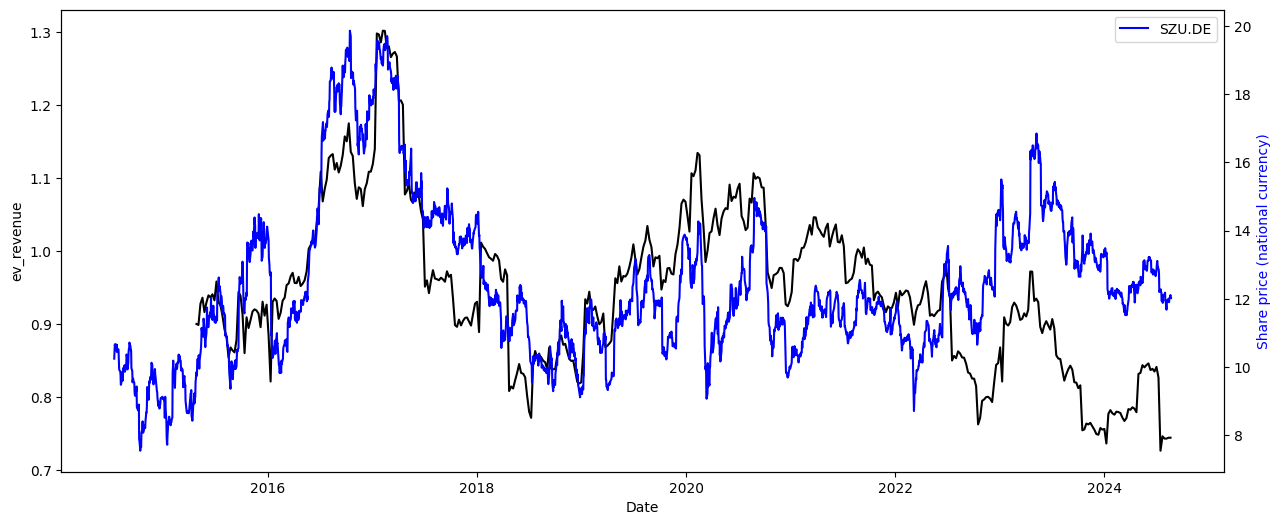

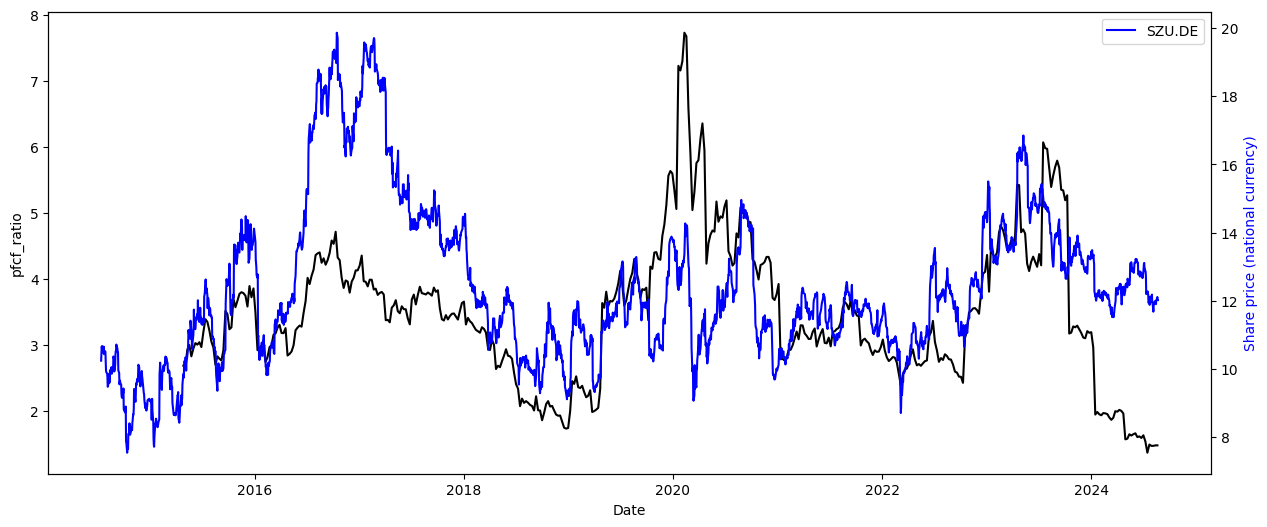

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

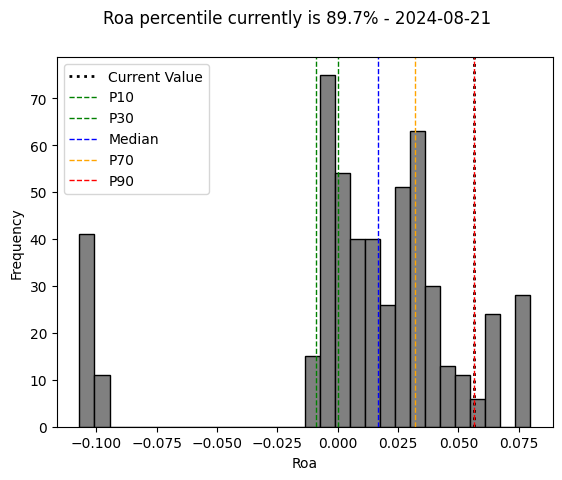

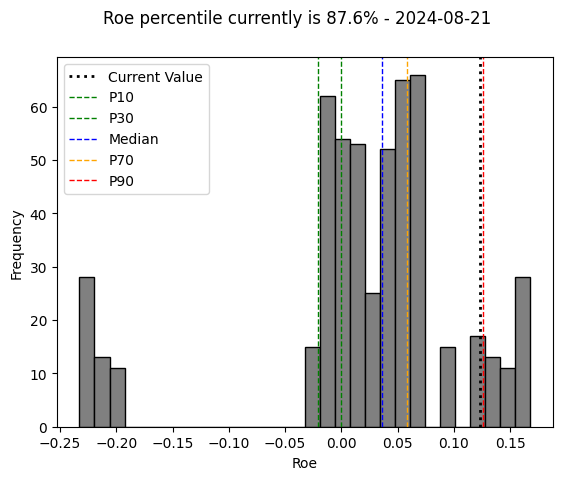

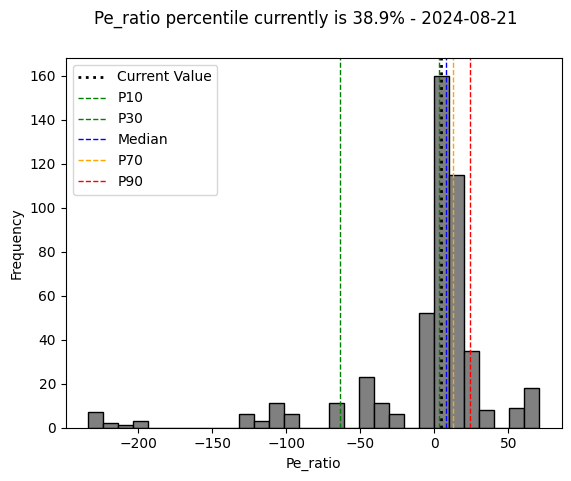

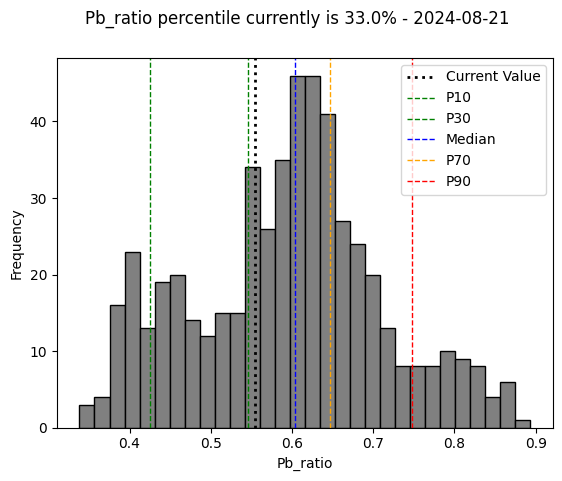

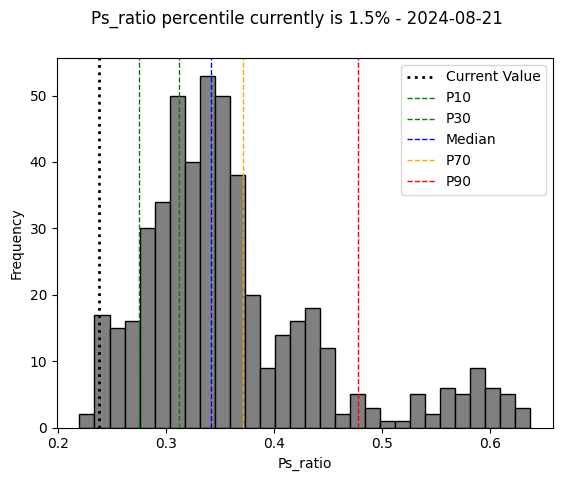

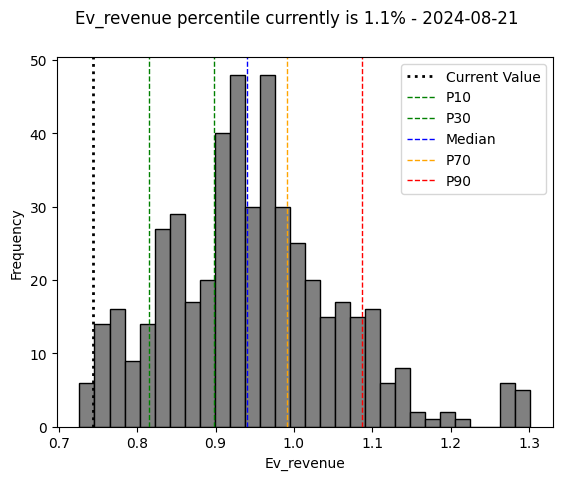

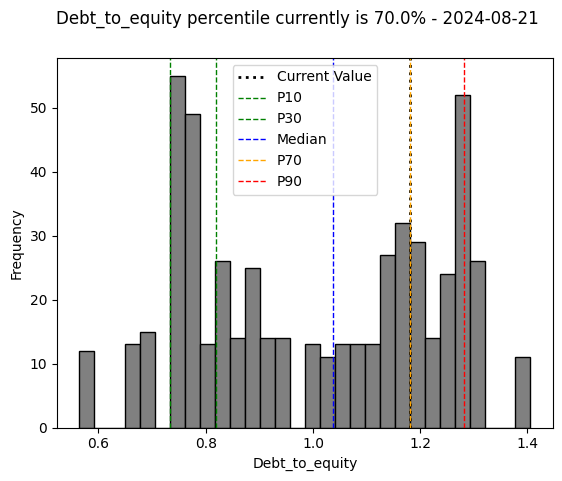

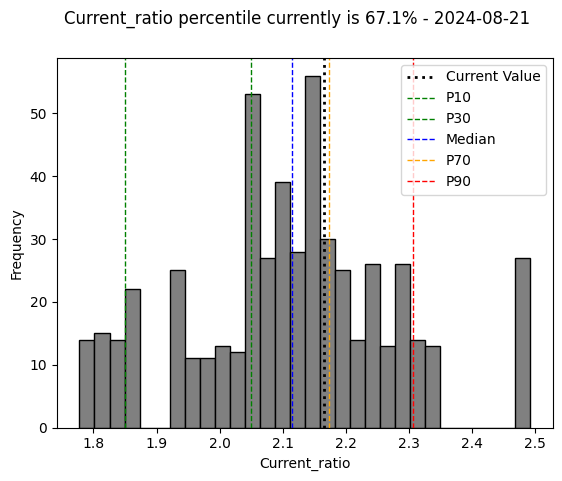

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996706,0.161880,-0.017093,-0.081115,-0.381373,-0.120549,-0.268397
roe,0.996706,1.000000,0.151484,-0.008580,-0.121305,-0.401545,-0.063157,-0.280957
pe_ratio,0.161880,0.151484,1.000000,-0.204548,0.069457,-0.163169,-0.386589,-0.422667
pb_ratio,-0.017093,-0.008580,-0.204548,1.000000,0.622829,0.637655,0.397485,0.139618
ps_ratio,-0.081115,-0.121305,0.069457,0.622829,1.000000,0.826630,-0.460211,-0.049966
ev_revenue,-0.381373,-0.401545,-0.163169,0.637655,0.826630,1.000000,-0.051007,-0.054756
debt_to_equity,-0.120549,-0.063157,-0.386589,0.397485,-0.460211,-0.051007,1.000000,0.062771
current_ratio,-0.268397,-0.280957,-0.422667,0.139618,-0.049966,-0.054756,0.062771,1.000000


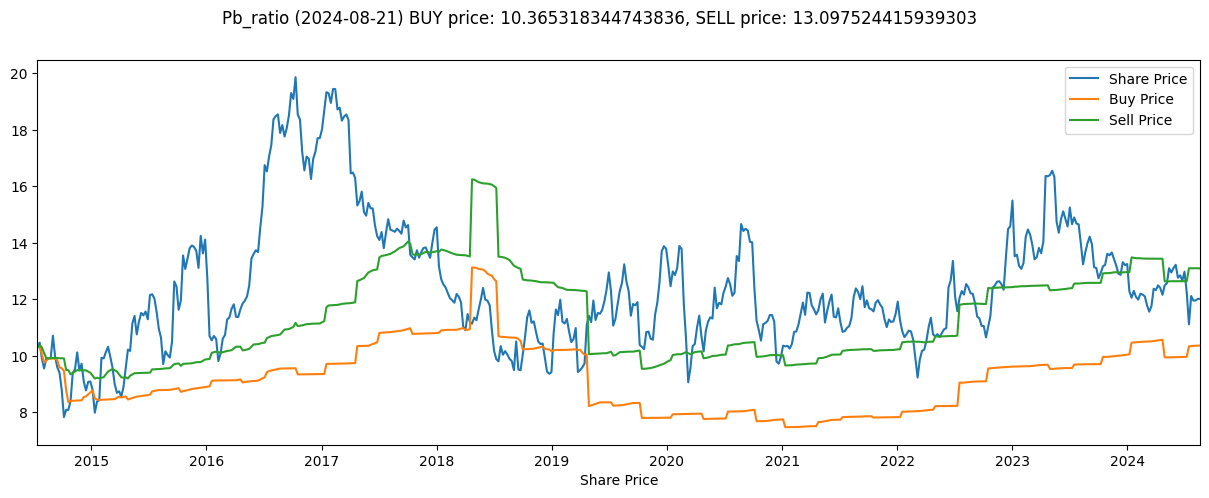

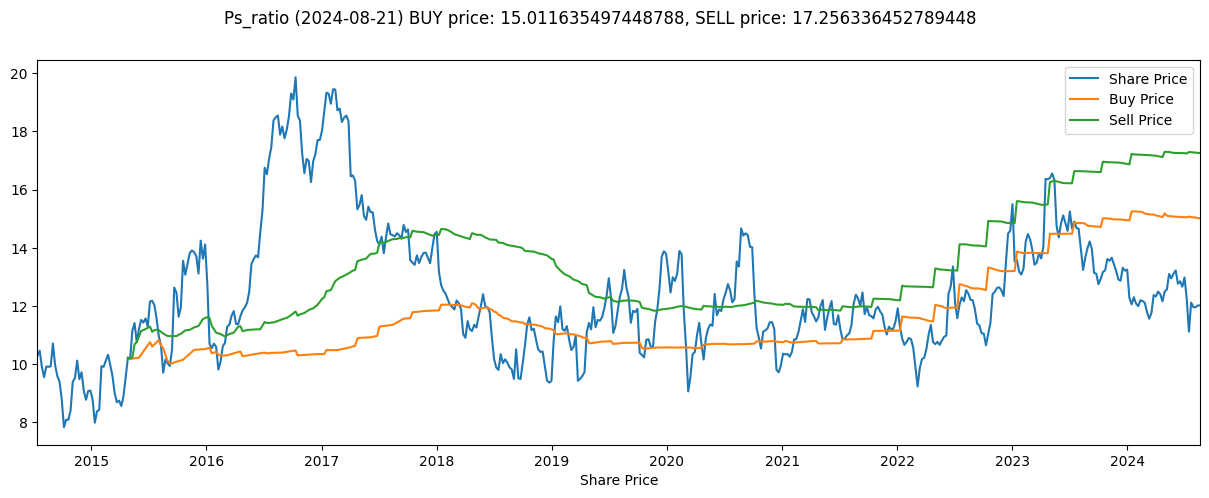

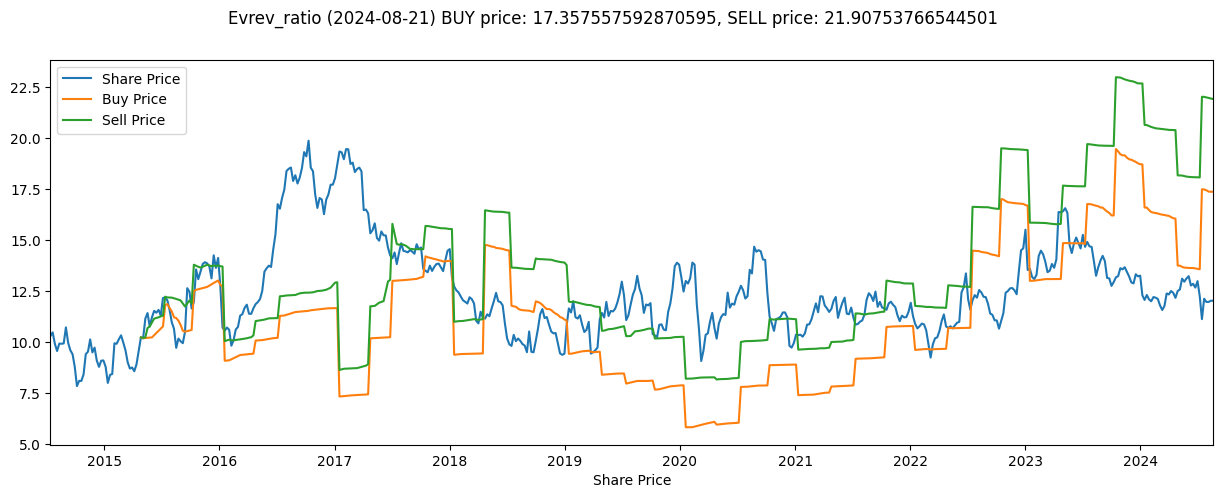

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)